# Challenge MDI343 

Mohamed AL ANI, le 29/01/2017

### Résumé des recherches effectuées : 

Pour ce Challenge, qui consiste à classifier des images (hommes ou femmes) selon 128 variable, j'ai testé plusieurs stratégies : 

**Stratégie Générale : ** 
- Avant la modélisation, quelques prétraitements et fonctions étaient nécessaires. Etant donné le nombre élevé de variables qui ralentissaient énormément l'exécution lors de la modélisation, j'ai commencé par effectuer de la feature selection. J'ai tenté un test de Fischer au risque 5%, ce qui a retiré 5 variables.
- Le challenge a un format de réstitution particulier. En effet, il permet de cibler la population et, lorsque pour certaines images nous ne sommes pas sûrs du résultat, il permet de ne pas se prononcer et dire "je ne sais pas" en mettant un 0 à l'observation prédite. Bien sûr, lorsque l'on se trompe, nous somme beaucoup plus pénalisés que lorsque l'on ne se prononce pas. Mon idée était alors de trouver les seuils optimaux qui déterminent la "non-prononciation" et ainsi réduire l'erreur du challenge. J'ai alors codé une fonction qui trouve les seuils pour les femmes et les hommes qui minimisent l'erreur du challenge ainsi qu'une fonction qui s'occupe de cross-valider les seuils. 

Pour la modélisation, j'ai testé plusieurs stratégies : 

**Stratégie Modélisation 1 : KNN subset / SVM** 
- Le test de Fischer n'écartant pas assez de variables, j'ai cherché une solution afin d'accélerer les temps d'exécution. En effet, lorsque je procédais à une Cross-Validation des hyper paramètres, cela pouvait prendre parfois plus d'une journée entière à tourner. J'ai estimé aussi que le nombre d'observation était beaucoup trop élevé et que cela n'avait que très peu d'intérêt. J'ai alors tenté de réduire le dataset d'apprentissage. Le problème est qu'en séléctionnant un échantillon aléatoire, je risquais de perdre de l'information. J'ai alors séléctionné les k plus proches voisins de l'échantillon de test dans mon échantillon train. Cela a créé un sous échantillon ressemblant à mon échantillon de test. Et ainsi, le risque de perdre de l'information est fortement réduit. 
    
**Stratégie Modélisation 2 : KNN Subset / AdaBoost - SVM**
- les SVM semblant donner de bons résultats, j'ai tenté un boosting en utilisant AdaBoost sur mon knn subset. 

**Stratégie Modélisation 3 : KNN Subset puis Tout le dataset / Multi Model "Boosting"**
- Lorsque je tentais des modélisations avec plusieurs modèles différents, j'ai remarqué que ceux ci ne donnaient pas toujours les mêmes résultats. Notamment pour certaines prédictions qui présentaient beaucoup de variances au niveau des probabilités de prédiction. J'en ai déduit que tous les modèles ne faisaient pas toujours les mêmes erreurs. J'ai voulu ainsi pouvoir "mélanger" tous ces classifieurs pour tenter ensuite de créer un modèle sur ces classifieurs qui éventuellement, pourra repérer les motifs des observations qui présentent des incertitudes et les généraliser. J'ai alors stocké dans une matrice les probabilités prédites de 8 classifieurs sur le dataset de train et test. Cela réduisait le nombre de variable à 8. J'ai ensuite construit plusieurs modèles différents sur ces datasets de prédiction. 

**Stratégie Modélisation 4 : KNN Subset puis Tout le dataset / Multi Model : Vote à la majorité, moyenne**
- Enfin, plutôt que créer un modèle sur la matrice de prédiction, j'ai pensé qu'effectuer un vote à la majorité sur les différents modèles pourrait trouver de la pertinence étant donné que l'on peut se permettre de ne pas se prononcer sur certaines observations. J'ai aussi tenté d'effectuer la moyenne des prédictions 

Pour un certain confort de lecture, dans ce notebook je n'ai mis que les modèles qui ont le mieux fonctionné. J'ai préféré supprimer toutes les recherches que j'ai effectué avec d'autres modèles.

## Imports

In [226]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.svm import SVC
from scipy.stats import shapiro

### On importe les données

In [227]:
X_train_fname = 'training_templates.csv'
y_train_fname = 'training_labels.txt'
X_test_fname  = 'testing_templates.csv'
X = pd.read_csv(X_train_fname, sep=',', header=None)
X_test  = pd.read_csv(X_test_fname,  sep=',', header=None).values
y = np.loadtxt(y_train_fname, dtype=np.int)

## Critère de performance 

Score entre 0 et 10. Plus le score est petit, mieux c'est 

In [228]:
# Critere de performance du challenge
def compute_pred_score(y_true, y_pred):
    y_comp = y_true * y_pred
    score = float(10*np.sum(y_comp == -1) + np.sum(y_comp == 0))
    score /= y_comp.shape[0]
    return score

## Feature Selection 

On effectue ici un test de Fisher au risque 5% pour tester l'influence des variables sur notre variable cible. On écarte les variables non influentes

(105600, 122)
(8496, 122)


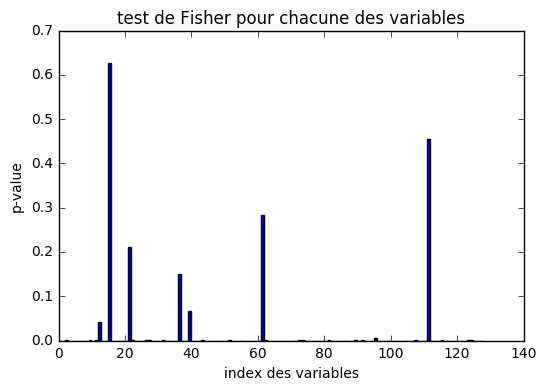

In [229]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectFpr
plt.figure()
plt.bar(np.arange(X.shape[1]), f_classif(X,y)[1])
plt.xlabel("index des variables")
plt.ylabel("p-value")
plt.title("test de Fisher pour chacune des variables")
fpr = SelectFpr(f_classif, 0.05)
X = fpr.fit_transform(X,y)
X_test = fpr.transform(X_test)

print(X.shape)
print(X_test.shape)    

## Fonctions utiles

In [238]:
#Fonction permettant de trouver les deux seuils optimaux pour cibler la population (1,-1 ou 0)
def populationACibler(probas, y_train, pas = 0.01):
    arraySteps = np.arange(0,0.5, pas)
    
    scoresG = []
    scoresD = []
    testG = {}
    testD = {}
    y_vectG = {}
    y_vectD = {}
    
    for step in arraySteps: 
        y_pred_step = [1 if proba < step else -1 if proba > 0.5 else 0 for proba in probas]
        score = compute_pred_score(y_train, y_pred_step)
        scoresG.append(score)
        testG[step] = score
        y_vectG[step] = y_pred_step
        
    for step in arraySteps: 
        y_pred_step = [1 if proba < 0.5 else -1 if proba > 1-step else 0 for proba in probas]
        score = compute_pred_score(y_train, y_pred_step)
        scoresD.append(score)
        testD[step] = score
        y_vectD[step] = y_pred_step
    
    plt.figure(1)
    plt.plot(arraySteps, scoresG, label="erreur des négatifs")
    plt.xlabel("% de la population à cibler (<seuil : 1, >1-seuil : -1, sinon : 0)")
    plt.ylabel("Erreur")
    plt.title("Erreur en fonction de la population à cibler")
    pourcentageG = min(testG, key=testG.get)
    print("proba à cibler -1  : %s et moins" %pourcentageG)
    
    plt.plot(1-arraySteps, scoresD, label="erreur des positifs")
    plt.xlabel("% de la population à cibler (<seuil des Negatifs : -1, > seuil des positifs : 1, sinon : 0)")
    plt.ylabel("Erreur")
    plt.title("Erreur en fonction de la population à cibler")
    pourcentageD = min(testD, key=testD.get)
    print("pourcentage à cibler 1 : %s et plus" %(1-pourcentageD))

    y_pred = [1 if proba < pourcentageG else -1 if proba > 1-pourcentageD else 0 for proba in probas]
    score = compute_pred_score(y_train, y_pred)
    print("erreur : "+str(score))
    
    return(pourcentageG, 1-pourcentageD, score)

#Fonction à mettre dans le GridSearch, renvoyant 1-erreur
def calcul_score_cible(clf, X, y):
    return(1-populationACibler(clf.predict_proba(X)[:,0], y, pas = 0.01)[2])
    

#Fonction d'export du txt avec les prédictions sur le dataset de test
def export_txt(clf, X_test, probaG, probaD): 
    probasTest = clf.predict_proba(X_test)[:,0]
    y_opt_test = [1 if proba < probaG else -1 if proba > probaD else 0 for proba in probasTest]
    np.savetxt('y_pred.txt', y_opt_test, fmt='%d')
    
#Fonction permettant de cross_valider les seuils 
def cross_valid_seuil(clf, X, y, n_splits=5):
    seuils = np.zeros([2,n_splits])
    ss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.3, random_state=42)
    i=0
    for train_index, test_index in ss.split(X, y):
        X_tr, X_te = X[train_index], X[test_index]
        y_tr, y_te = y[train_index], y[test_index]
        clf.fit(X_tr, y_tr)
        probas = clf.predict_proba(X_te)[:,0]
        pop = populationACibler(probas, y_te, pas = 0.01)
        seuils[0,i] = pop[0]
        seuils[1,i] = pop[1]
        i+=1
    return(np.mean(seuils, axis=1))

#Etant donné que nous avons beaucoup de données d'apprentissage (environ 100k) comparé à nos données de test (8,7k), on crée un
#sous ensemble d'apprentissage. Nous cherchons ainsi un sous ensemble ressemblant à nos données de test. Pour faire cela, nous
#utilisons un knn et cherchons dans notre dataset d'apprentissage les k plus proches voisins de nos données de test. 
def subset_KNN(X, y, X_test, k=3): 

    estimator_k3 = KNeighborsClassifier(algorithm='auto',n_neighbors=k, leaf_size=30, metric='euclidean',
                                     metric_params=None, n_jobs=-1, p=2,
                                     weights='distance')

    estimator_k3.fit(X, y)

    # Recherche des points les plus proches pour entrainer notre SVM
    n_neibor_idx = estimator_k3.kneighbors(X_test)[1]
    n_neibor_idx.reshape((-1,1))
    train_not_unique = n_neibor_idx.reshape((-1,1))
    train_unique = np.unique(train_not_unique)

    X_unique = X[train_unique,:]
    y_unique = y[train_unique]
    
    return (X_unique, y_unique)
    
    

## Insights

In [231]:
X.shape, X_test.shape, y.shape

((105600, 122), (8496, 122), (105600,))

In [232]:
print('n_samples : %d, n_features : %d' % X.shape)

n_samples : 105600, n_features : 122


## Modelisation 

Nous testerons plusieurs modèles sur notre subset...

#### Création du subset : 

Voir cellule "fonctions utiles"

In [17]:
X_unique, y_unique = subset_KNN(X, y, X_test, k=3)
print(X_unique.shape, y_unique.shape )

(17137, 122) (17137,)


### Logistic Regression

In [154]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'dual' : [True, False],
             'fit_intercept' : [True, False]}

clf = GridSearchCV(LogisticRegression(), param_grid, scoring=calcul_score_cible, cv=5)
clf.fit(X_unique, y_unique)

#clf = LogisticRegression()

Saving the model for future use : 

In [155]:
joblib.dump(clf, 'logisticRegressionV1.pkl') 

Loading the model : 

In [233]:
clf = joblib.load('logisticRegressionV1.pkl')

**Evaluation du modèle : **

proba à cibler -1  : 0.12 et moins
pourcentage à cibler 1 : 0.9 et plus
erreur : 0.2891870867366783
proba à cibler -1  : 0.13 et moins
pourcentage à cibler 1 : 0.93 et plus
erreur : 0.2954103461688059
proba à cibler -1  : 0.14 et moins
pourcentage à cibler 1 : 0.92 et plus
erreur : 0.2897705173084403
proba à cibler -1  : 0.15 et moins
pourcentage à cibler 1 : 0.89 et plus
erreur : 0.26721120186697783
proba à cibler -1  : 0.11 et moins
pourcentage à cibler 1 : 0.87 et plus
erreur : 0.26662777129521587


array([ 0.13 ,  0.902])

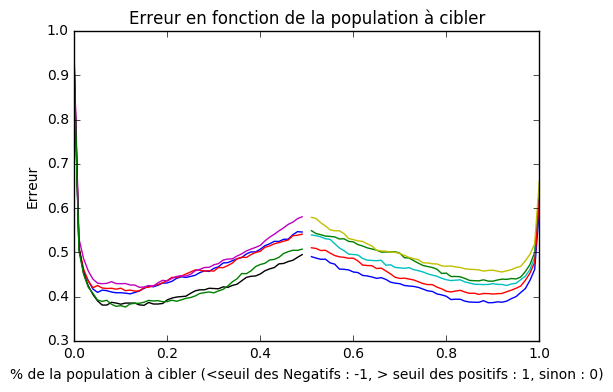

In [239]:
clf.fit(X_unique,y_unique)
probas = clf.predict_proba(X)[:,0]

cross_valid_seuil(clf, X_unique, y_unique)


In [152]:
export_txt(clf, X_test, probaG, probaD)

Score de 0.631355932203

### MLPClassifier

#### Grid search cv pour trouver les meilleurs paramètres : 

In [40]:
%%time 
param_grid = {"activation" : ['identity', 'logistic', 'tanh', 'relu'],
             "solver" : ['lbfgs', 'sgd', 'adam'], 
              "alpha" : [0.0001, 0.001, 0.01, 0.1, 1]
             }

GSCV = GridSearchCV(MLPClassifier(), param_grid, scoring=calcul_score_cible, cv = 5)
GSCV.fit(X_train, y_train)
print(GSCV.best_score_ )
print(GSCV.best_estimator_)


C:\Users\Mohamed\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
C:\Users\Mohamed\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
C:\Users\Mohamed\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
C:\Users\Mohamed\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
C:\Users\Mohamed\Anaconda3\lib\site-packages\skl

1.11458333333
MLPClassifier(activation='logistic', alpha=1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
Wall time: 11h 28min 7s


In [54]:
GSCV.cv_results_

joblib.dump(GSCV, 'GridMLP.pkl') 

['GridMLP.pkl']

**On cross-valid les seuils pour trouver les meilleurs pourcentage de population à cibler**

proba à cibler -1  : 0.02 et moins
pourcentage à cibler 1 : 0.95 et plus
erreur : 0.12038117464021782
proba à cibler -1  : 0.01 et moins
pourcentage à cibler 1 : 0.95 et plus
erreur : 0.11804745235316998
proba à cibler -1  : 0.01 et moins
pourcentage à cibler 1 : 0.99 et plus
erreur : 0.11940879035394789
proba à cibler -1  : 0.03 et moins
pourcentage à cibler 1 : 0.96 et plus
erreur : 0.11435239206534423
proba à cibler -1  : 0.01 et moins
pourcentage à cibler 1 : 0.93 et plus
erreur : 0.09918319719953325
[ 0.016  0.956]
Wall time: 13.9 s


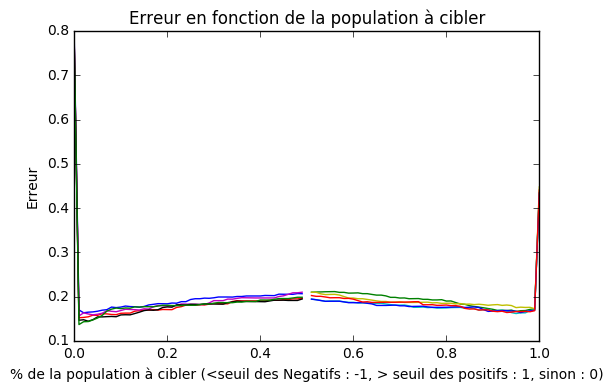

In [240]:
%%time 
#{‘identity’, ‘logistic’, ‘tanh’, ‘relu’}
mlp = MLPClassifier(hidden_layer_sizes=100, activation= 'relu', alpha=0.001, solver= "adam", learning_rate_init=0.01, \
                    early_stopping=False, validation_fraction=0.4, beta_1=0.1, beta_2=0.9999)

print(cross_valid_seuil(mlp, X_unique, y_unique))

On crée le fichier txt correspondant : 

In [86]:
export_txt(mlp, X_test, 0.016, 0.956)

Score de 0.16 sur le leaderboard

### SVM


On crée notre subset : 

In [8]:
X_unique, y_unique = subset_KNN(X, y, X_test, k=1)

Grid search pour les hyper paramètres : 

In [ ]:
svm = SVC(probability=True, kernel='rbf')
svm_params = {
    'C': [4,5,6],
    'gamma': [1.3, 1.4, 1.5, 1.6],
}

grid = GridSearchCV(svm, svm_params, cv=4,verbose=1,n_jobs=2)

grid.fit(X_unique, y_unique)

In [ ]:
print(1-grid.best_score_)
print(grid.best_params_)

On cross valid les seuils : 

proba à cibler -1  : 0.1 et moins
pourcentage à cibler 1 : 0.88 et plus
erreur : 0.10171139634383508
proba à cibler -1  : 0.09 et moins
pourcentage à cibler 1 : 0.87 et plus
erreur : 0.09782185919875534
proba à cibler -1  : 0.1 et moins
pourcentage à cibler 1 : 0.83 et plus
erreur : 0.09646052119797745
proba à cibler -1  : 0.07 et moins
pourcentage à cibler 1 : 0.92 et plus
erreur : 0.08556981719175417
proba à cibler -1  : 0.08 et moins
pourcentage à cibler 1 : 0.81 et plus
erreur : 0.08887592376507196


array([ 0.088,  0.862])

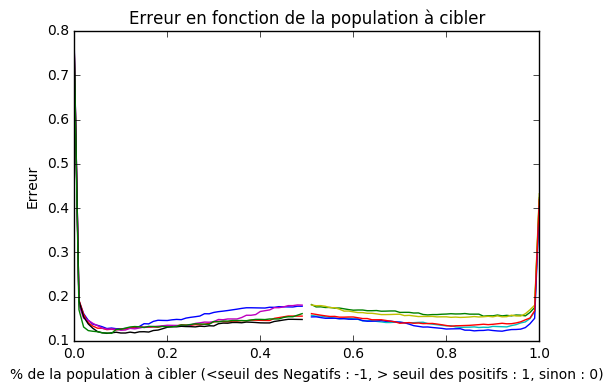

In [88]:
svm = SVC(probability=True, C=5, kernel='rbf', gamma = 1.4, random_state=40)
cross_valid_seuil(svm, X_unique, y_unique)

In [95]:
svm.fit(X_unique, y_unique)
export_txt(svm, X_test, 0.088, 0.862)

Score de 0.1399

### Boosting 

On teste un Adaboost / svm : 

In [11]:
%%time 
from sklearn.ensemble import AdaBoostClassifier

X_unique, y_unique = subset_KNN(X, y, X_test, k=3)

ada = AdaBoostClassifier(base_estimator=SVC(probability=True, C = 5, gamma = 1.5), n_estimators=5)
ada.fit(X_unique, y_unique)

Wall time: 36min 3s


In [13]:
joblib.dump(ada, 'ada.pkl') 

['ada.pkl']

On ne cross valide pas les seuils étant donné les temps d'exécution : 

proba à cibler -1  : 0.46 et moins
pourcentage à cibler 1 : 0.77 et plus
erreur : 0.33389741495010794


(0.46000000000000002, 0.77000000000000002, 0.33389741495010794)

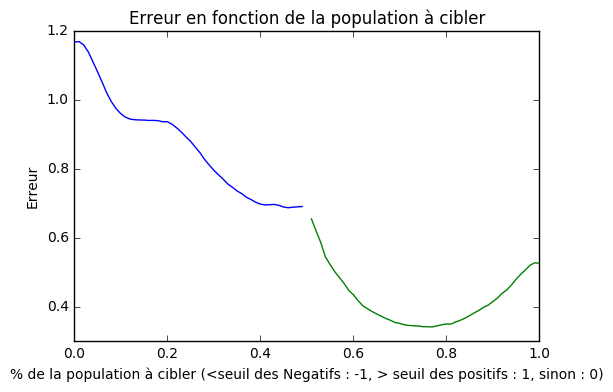

In [14]:
populationACibler(ada.predict_proba(X_unique)[:,0], y_unique, pas = 0.01)

Le modèle n'a pas donné de bons résultats sur le leaderboard : 0.60

### Multi Model Boosting : 

In [80]:
%%time 

#Fonction permettant de créer 2 nouvelles matrices contenant les vecteurs de prédictions de plusieurs classifieurs. 
def multi_model_boosting(X_tr, y_tr, X_te):
    
    classifiers = [SVC(probability=True, C=5, gamma=1.5), SVC(probability=True, kernel="poly"), \
                   MLPClassifier(), KNeighborsClassifier(), GaussianNB(), SVC(probability=True, kernel="linear"),\
                   DecisionTreeClassifier(max_depth=10), LogisticRegression(C=100, dual=False, fit_intercept=True)]


    train_probs = np.zeros([X_tr.shape[0], len(classifiers)])
    test_probs = np.zeros([X_te.shape[0], len(classifiers)])

    for i, clf in enumerate(classifiers): 
        clf.fit(X_tr, y_tr)
        train_probs[:,i] = clf.predict_proba(X_tr)[:,0]
        test_probs[:,i] = clf.predict_proba(X_te)[:,0]

    return(train_probs, test_probs)



Wall time: 0 ns


#### Data = subset knn 

On crée un sous set de validation pour tester plusieurs modèles par la suite. On ne cross valide pas vu les temps d'exécution. 

In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(X_unique, y_unique, test_size=0.33, random_state=42)
train_probs, test_probs = multi_model_boosting(X_tr, y_tr, X_te)

proba à cibler -1  : 0.01 et moins
pourcentage à cibler 1 : 0.99 et plus
erreur : 0.10095473833097596


(0.01, 0.98999999999999999, 0.10095473833097596)

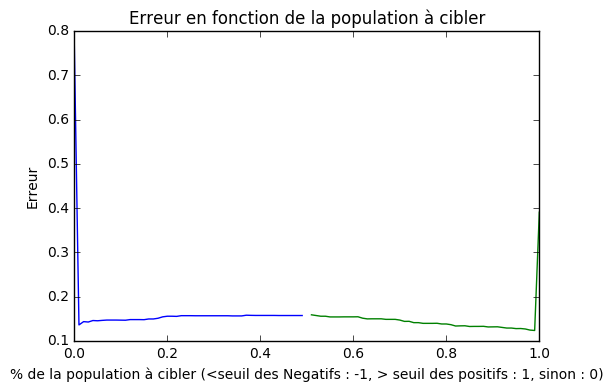

In [78]:
rfc = MLPClassifier()
rfc.fit(train_probs, y_tr)
populationACibler(rfc.predict_proba(test_probs)[:,0], y_te, 0.01)


In [141]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.33, random_state=42)
train_probs1, test_probs1 = multi_model_boosting(X_tr, y_tr, X_te)

TypeError: Invalid parameters passed: {'max_features': 0.5}

Résultat sur le leaderboard : > 0.20, insatisfaisant.

#### Data = tout le dataset train : 

In [86]:
train_probs, test_probs = multi_model_boosting(X, y, X_test)

proba à cibler -1  : 0.001 et moins
pourcentage à cibler 1 : 0.993 et plus
erreur : 0.10893021120293847


(0.001, 0.99299999999999999, 0.10893021120293847)

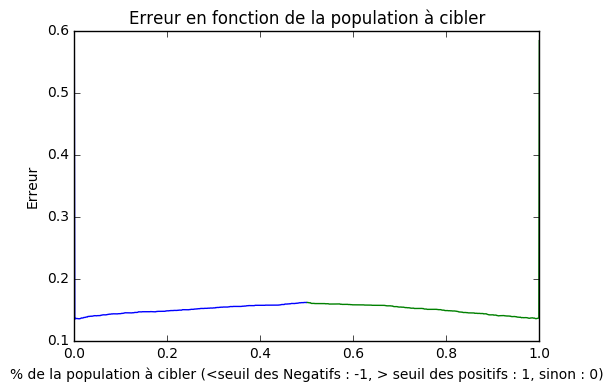

In [ ]:
rfc = RandomForestClassifier(n_estimators=1000, max_depth=3, n_jobs=-1, bootstrap=True)
rfc.fit(train_probs1, y_tr)
populationACibler(rfc.predict_proba(test_probs1)[:,0], y_te, 0.001)

In [ ]:
rfc.fit(train_probs, y)

In [ ]:
export_txt(rfc, test_probs, 0.001, 0.993)

Résultat > 0.16 sur le leaderboard, insatisfaisant. Je reste convaincu que cette approche était bonne mais je n'ai peut être pas choisi les bons modèles (les 3 svm à noyaux différents était peut être une mauvaise idée.